# Event-driven architectures
1. "Flash: an Efficient and Portable Web Server" vs Apache

### Which model is better 

When compare two different solutions, depends on metrics and who care about them. 

### Are t hreads useful?

Threads are useful because 
1. parallelization => speed up
1. specialization => hot cache
1. efficiency => lower memory requirement and cheaper synchronization

Threads hide latency of I/O operations (single CPU)


1. depends on metrics
1. depends on workload


1. Different number of toy orders => different implementation for toy shop
1. Different type of graph => different shortest path algoritham
1. Different file patterns => different file system

### What's useful

1. For a matrix multiply application: execution time
1. for a web service applciation: 
    1. number of client requests/time
    1. response time
    1. average, min, max, 95%
1. for hardware: higher utilization

Depends on metrics

Common metrics
1. Execution time
1. Throughput
1. Response time
1. Request rate
1. Utilization
1. Wait time
1. Platform efficiency
1. Performance/$
1. Performance/walt
1. Percentage of SLA (Service Level Agreement) violations
1. Client perceived performance
1. Aggregate performance (average of the past)
1. Average resource useage.
1. ....

Performance metrics: a measurement standard 
1. measurable and/or quantifiable property
1. of the system we are interested in
1. that ca nbe used to evaluate the system behavior
1. obtained from (testbed)
    1. experiments with real software deployment, real machines, real workloads
    1. 'toy' experiments representative of realistice settings
    1. simulation
1. in order to perform the evaluation and comparison, we should explore the values of the metrics over some meaningful range of parameters. Like workload, allocated resources, etc.


 

### How to best provide concurrency

#### multt process vs multi threads
Web server: concurrent processing of client requests
1. client/brower send request
1. web server accepts request
1. server procssing steps (some are more computational intensive, require interactions with network or the disk, they may be blocked depended on the status of the system)
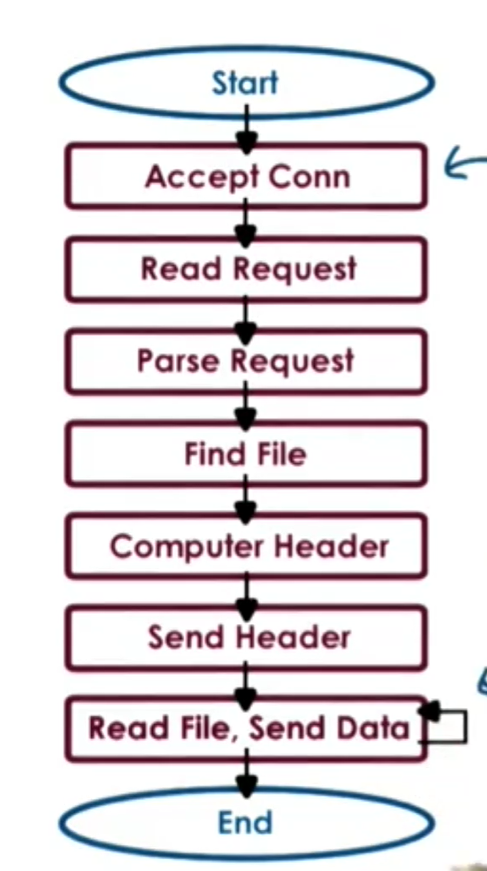
1. respond by sending file

#### Multi process (MP)
1. simple programming: many processes
1. high memory usage
1. costly context switch
1. hard/costly to maintain shared state 
1. tricky port setup, send to same address, share the same socket and port

#### Multi Threaded (MT)
1. Every thread performance accept connection through send data
1. Boss/worker

Pros:
1. Shared address space
1. Shared state
1. Cheap context swtich
Cons:
1. not simple implementation
1. requires synchronization
1. underlying OS support for threads.

### Event-Driven Model
1. Single address space
1. Single process
1. Single thread of control

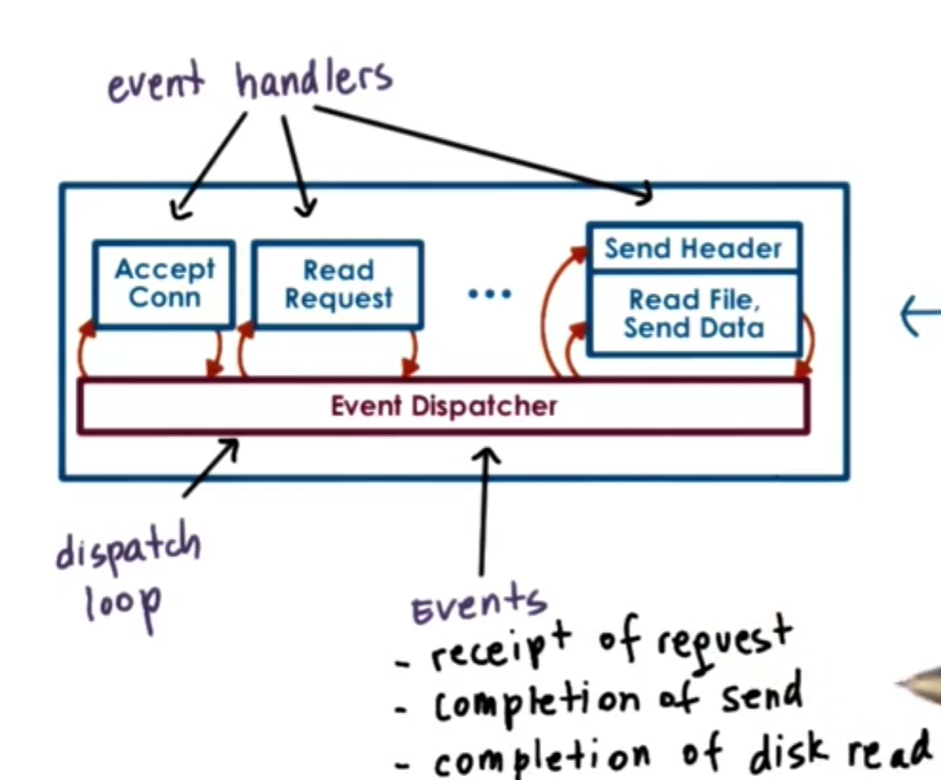

1. Dispatcher == state machine, can accept all types of the external event notifications and invoke the propreate handlers based on the type of notification. 
1. call handler == jump to code of the handler


Handler
1. run to completion
1. if they need to block: initiate blocking operation and pas control to dispatch loop. 

### Concurrent Execution in Event-Driven Model

In MP an dMT: one request per execution context (process/thread)

Event-driven: many requests interleaved in an execution context. A single thread switches among processing of different requests.

#### Why does this work
On 1 CPU "thread hide latency" 
1. if(t_idle>2* t_ctx_switch) then ctx_switch to hide latency.
1. if(t_idle == 0) then contex switching just wasts cycles that could have been used for request processing

### Event driven: 
1. Process request until wait necessary then switch to another request
1. Even with multi CPUs, multi event-driven processes hand handle more requests than current CPUs.
1. This has less overhead than context switching

### How does this work?
1. Sockets: interface of network
1. Files: interface of disk
1. File descritors: the actual data structure representing sockets and files is identical

#### which file descriptor?
1. select(): a range of descriptors and return the first one that has some input on it.
1. poll()
1. both select and poll need to scan a large list of descriptors among which there are only very few have input. A lot of search time will be wasted.
1. epoll()

### Benefits of Event-driven model
1. single address space
1. single flow of control
1. smaller memory requirement
1. no context switching
1. no synchronization


### Problem with Event-Driven Model

A single blocking request/handler call can block the whole process. 


### Asynchronous I/O operations
1. Process/thread makes system call
1. OS obtains all relevant info from stack and either learns where to return results or tells caller where to get results later.
1. process/thead can continue and later come back to check if the results are avaiable. 
1. Requires support from kernel (multi threads) and/or device (DMA)
1. OS can use select(), poll(), or epoll() with Event-Driven Model
1. Fits nicely with Event-Driven Model

### What if Async Calls are not available?
Helpers:
1. Designated for blocking I/O operations only
1. can communicate with helps with pip/socket based communication with event dispatcher. This can check if the helpers provide any events to the dispatcher
1. Async I/O call is handled by the helper. Helper blocks but main event loop (and procss) will not.
1. Make the helpers processes: Asymmetric Multi-Process Event-Driven Model (AMPED)/(AMTED).

Pros.
1. resolves portability limitation of basic event-driven model
1. smaller footprint than regular worker thread.
Cons:
1. Applicability to certain classes of applications
1. Event routing on multi CPU systems

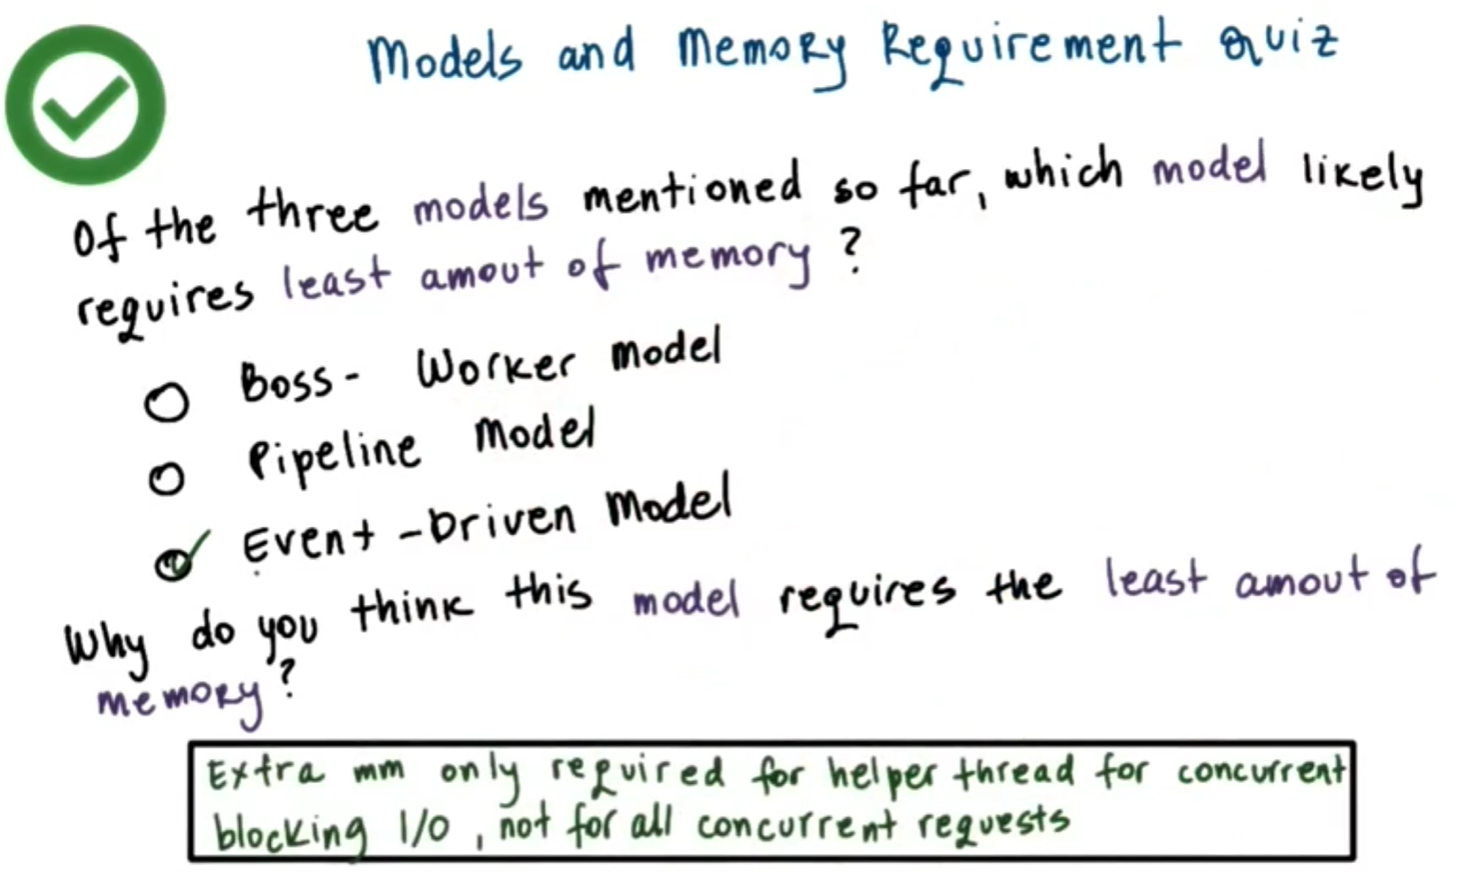


## Flash: Event-Driven Web Server
1. an event-driven webserver (AMPED)
1. with asymmetric helper processes to deal with blocking I/O operations
1. helpers used for disk reads
1. pipes used for comm with dispatcher
1. helper reads file in memory (via mmap call)
1. dispacther checks (via mincore) if pages of the file are in memory to decide 'local' handler or helper
1. the check can be possible big savings coz files might have been in the memory. 
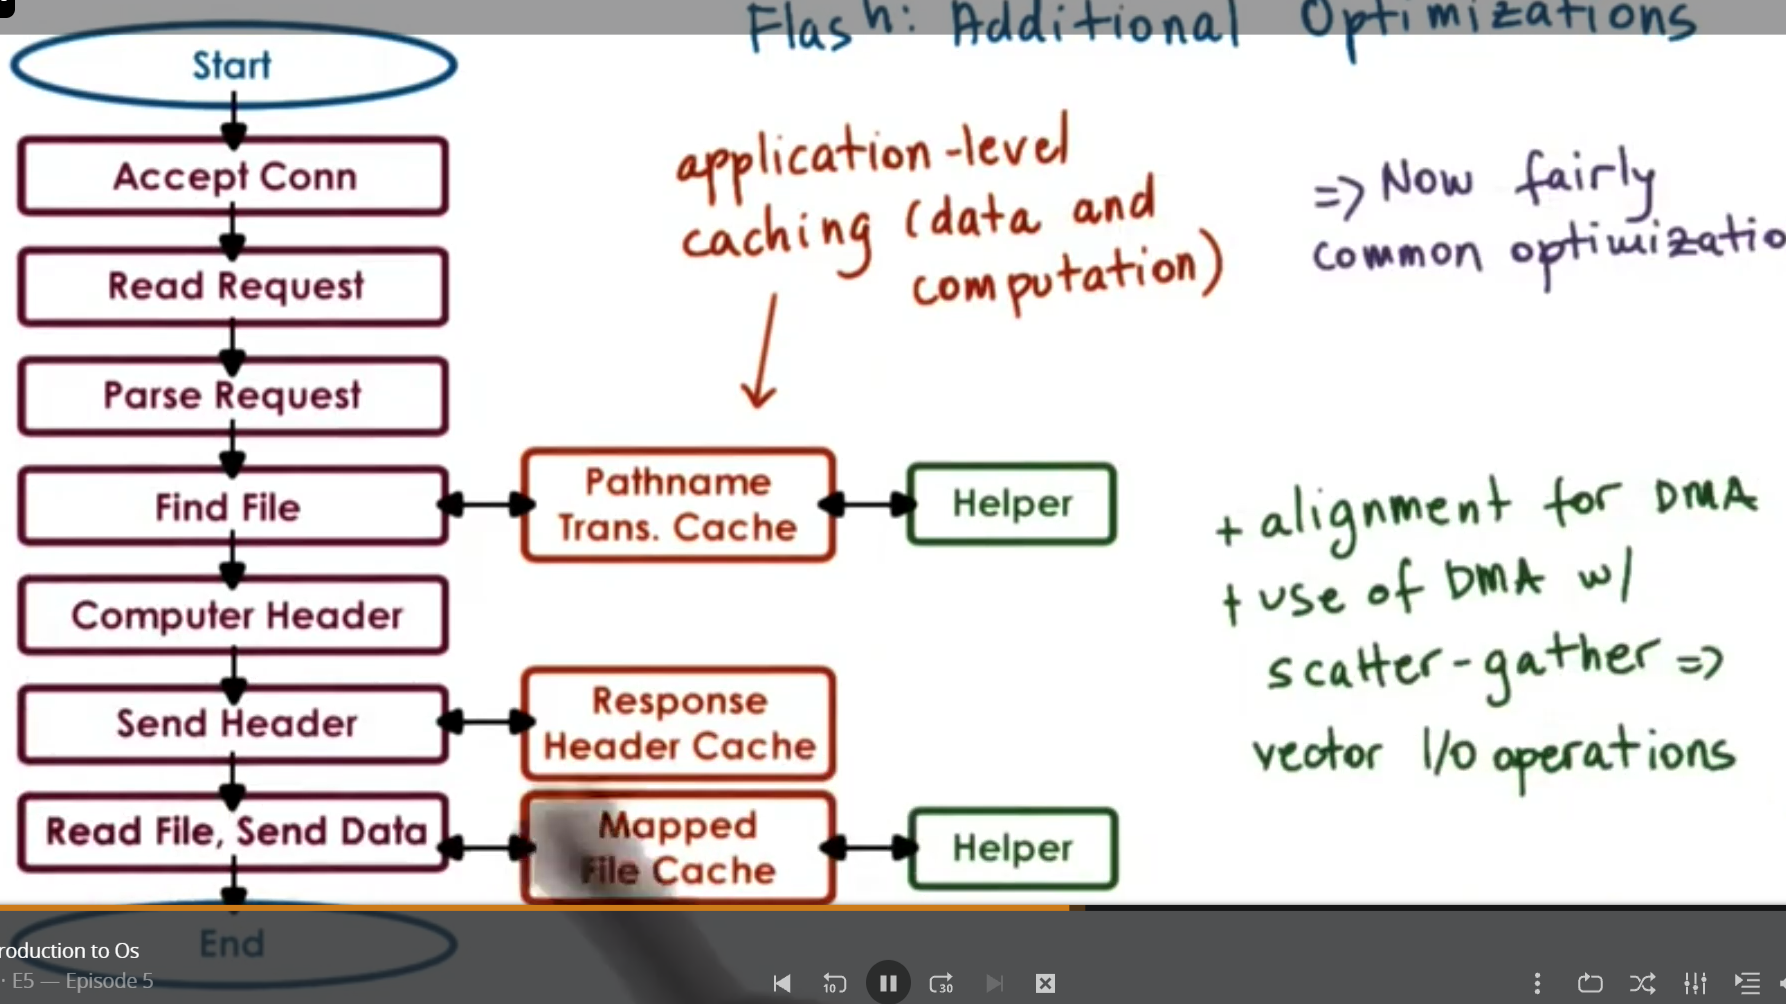

### Flash: additional optimization. 
1. application-level caching
    1. data: files
    1. computation: 
        1. Pathname trans. Cache (helper): look up directory data structure and cache the results 
        1. Response Header Cache: http header for each file
1. All the data structures are aligned for DMA operations
1. Use of DMA with scatter-gather (header and actual data don't have to be aligned one next to another, they can be send from different memory locations, so copies are avoided) =>vector I/O operations
1. All the features above are now fairly common optimizations but not at the time of the paper.

### Apache
1. Core: basic server skelethon, accepting connection and manage concurrency.
1. Modules: different types of functionality executed on each request.
1. Flow of control: similar to event-driven model. Every request go through all the modules
1. Combination of MP & MT
1. Each process/instance is a boss/worker with dynamic thread pool (configurable threadhold to increase/decrease the number of threads in the pool)
1. Number of oroceeses can also be dynamically adjusted.

### Setting Up Performance Comparison

1. Comparison points (what systems?)
    1. MP(each process gingle thread)
    1. MT(Boss-worker)
    1. Single Process Event-Driven (SPED)
    1. Zeus (SPED with 2 processes to deal with I/O blocking situation)
    1. Apache (v1.3.1, MP)
    1. For all but Apache, optimizations introduced by Flash paper are implimented
    1. Compare againsts Flash (AMPED model)
1. Inputs/workloads
    1. Realistic request workload: distribution of web page accesses over time
    1. Controlled, reproducible workload: trace-based (from real web servers)
    1. CS web server trace (Rice Univ): a large number of files which don't fit in the memory
    1. Owlnet trace (Rice Univ): student webpages, small files
    1. Synthetic workload generator (best/worst situation, what-if, ...)
    
1. Metrics
    1. Bandwith == bytes/time: total bytes transfered from files/total time
    1. Connection rate == Request/time: total client conn/total time
    1. Evalauted both a a function of file size
        1. larger file size
            1. ammortize per connection cost => higher bandwidth
            1. more work per connection => lower connection rate
            

### Best Case Numbers/Single File Trace
Synthetic load:
1. vary the number of requests for same file => best case
Measure Bandwidth:
1. $Bandwitdh = n*bytes(F)/time$
1. File size: 0-200kb: vary work per request

Obervations
1. All exhibit similar results
1. SPED has best performance 
1. Flash AMPED extra check for memory presence but there is no need to block I/O
1. Zeus has anomaly, due to misalign to DMA operations. 
1. MT/MP extra sync & context switching
1. Apache: lacks optimizations

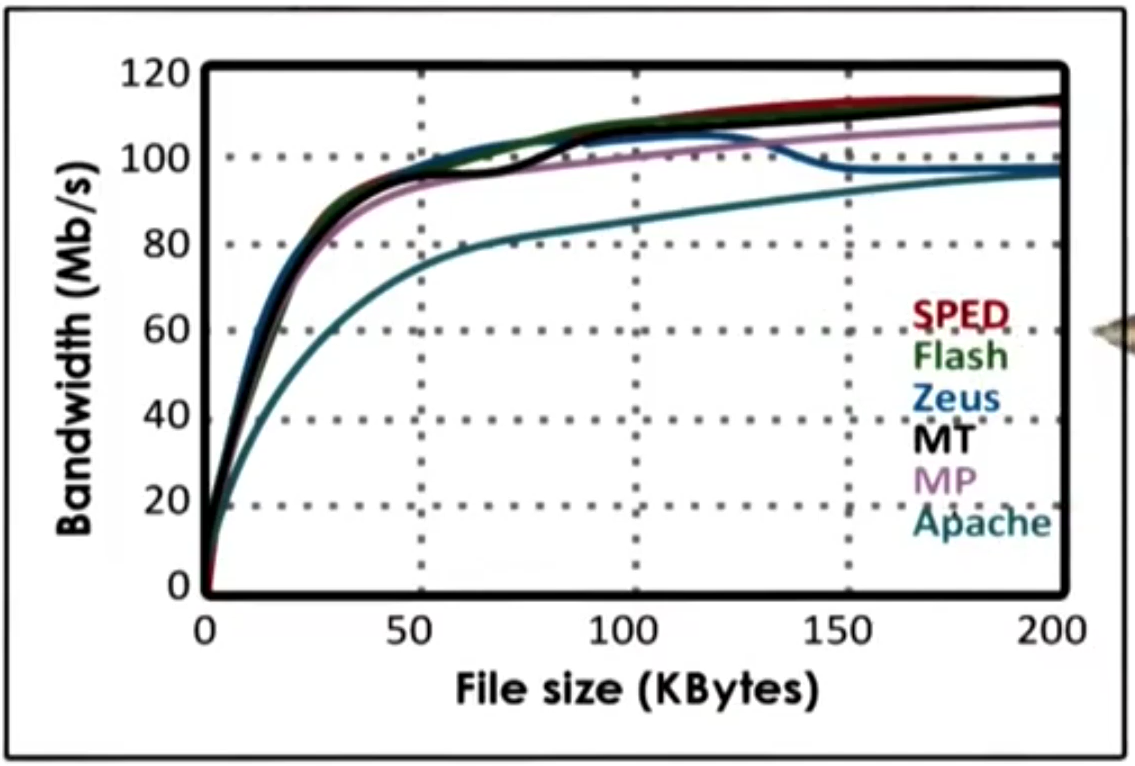

### Owlnet Trace/Small trace
1. Trends similar to "best" case
1. Small trace, mostly fits in cache
1. Sometimes blocking I/O is required
    1. SPED will block 
    1. Flash's helpers resolve the problem
    
### CS Trace/Large Trace
1. larger trace mostly requires I/O
1. SPED worst: lack of async I/O
1. MT better than MP
    1. smaller memory footprint => more memory to cache file and less I/O
    1. cheaper (faster) sync
1. Flash best
    1. smaller memory footprint
    1. more memory for caching
    1. fewer requests lead to blocking I/O
    1. no sync needed
    
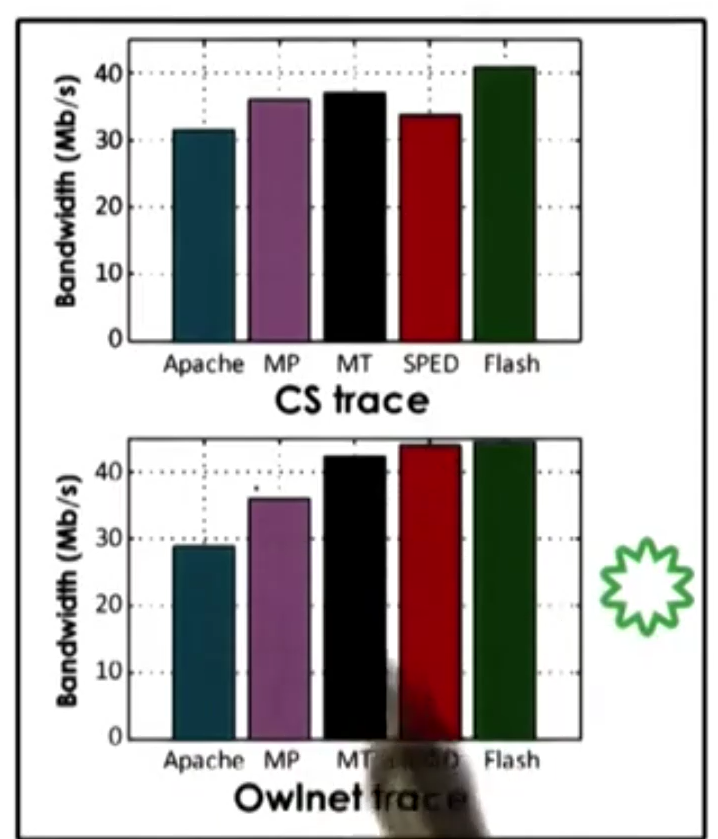

### Impact of Optimizations
1. Optimizations are important
1. Apache would have benefited too
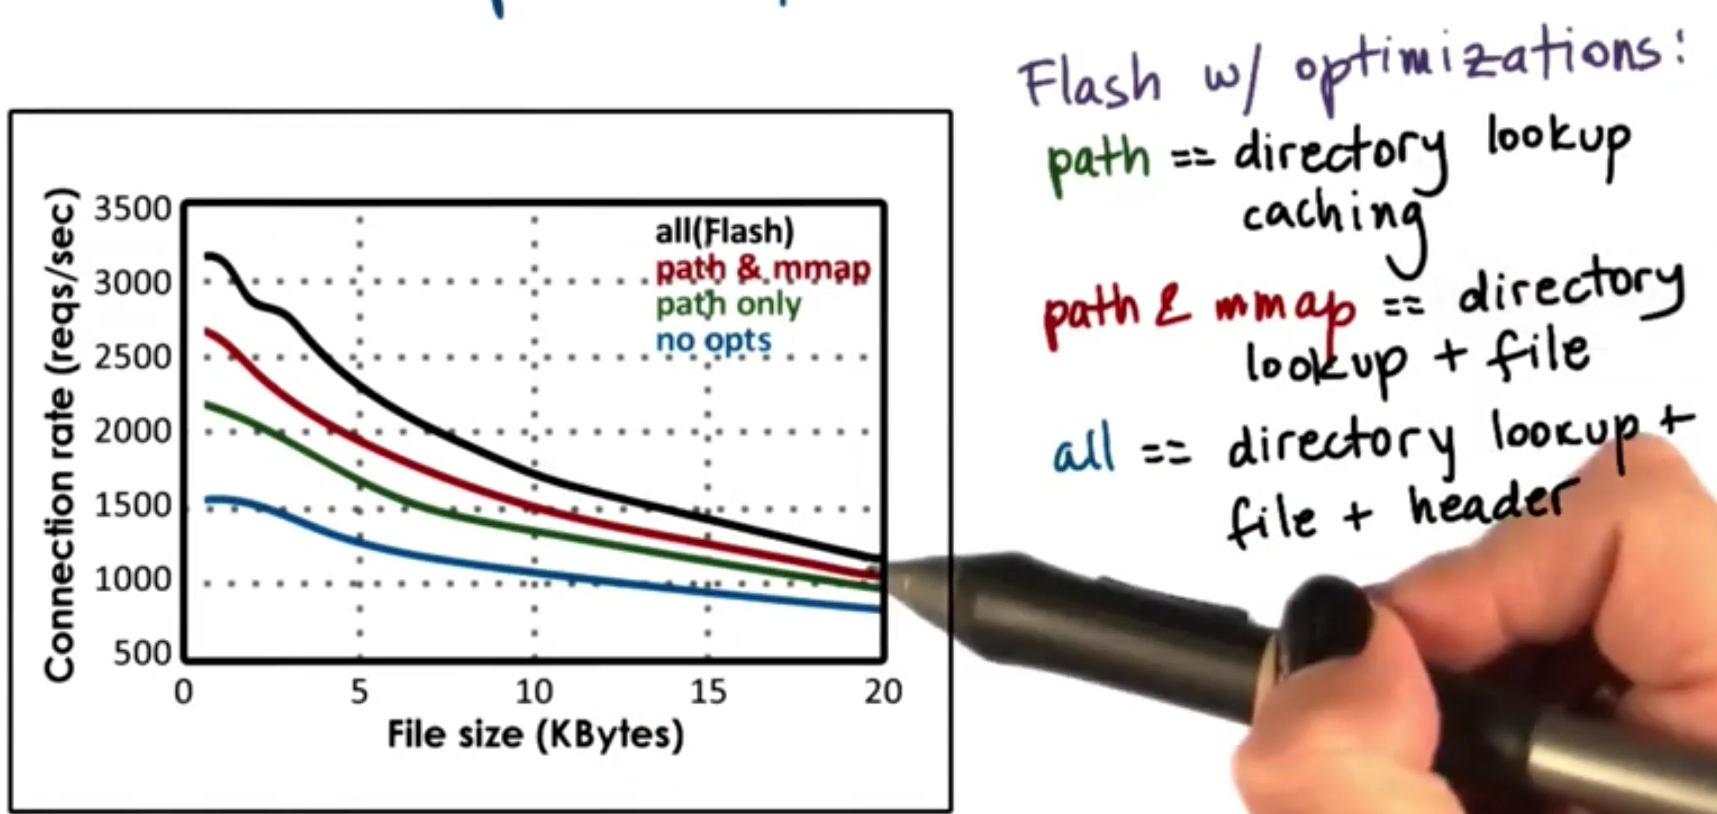

### Summary of performance results
1. When data is in cache:
    1. SPED >> AMPED Flash: unncecessary test for memory presence
    1. SPED & AMPED Flash >> MT/MP: Sync & context switching overhead
1. With disk-bound workload
    1. AMPED Flash >> SPED: blocks b/c no async I/O
    1. AMPED Flash >> MT/MP: more memory efficient and less context switching
1. Disadvantage of FLash: not for every applciation such as multi CPU/software architecture


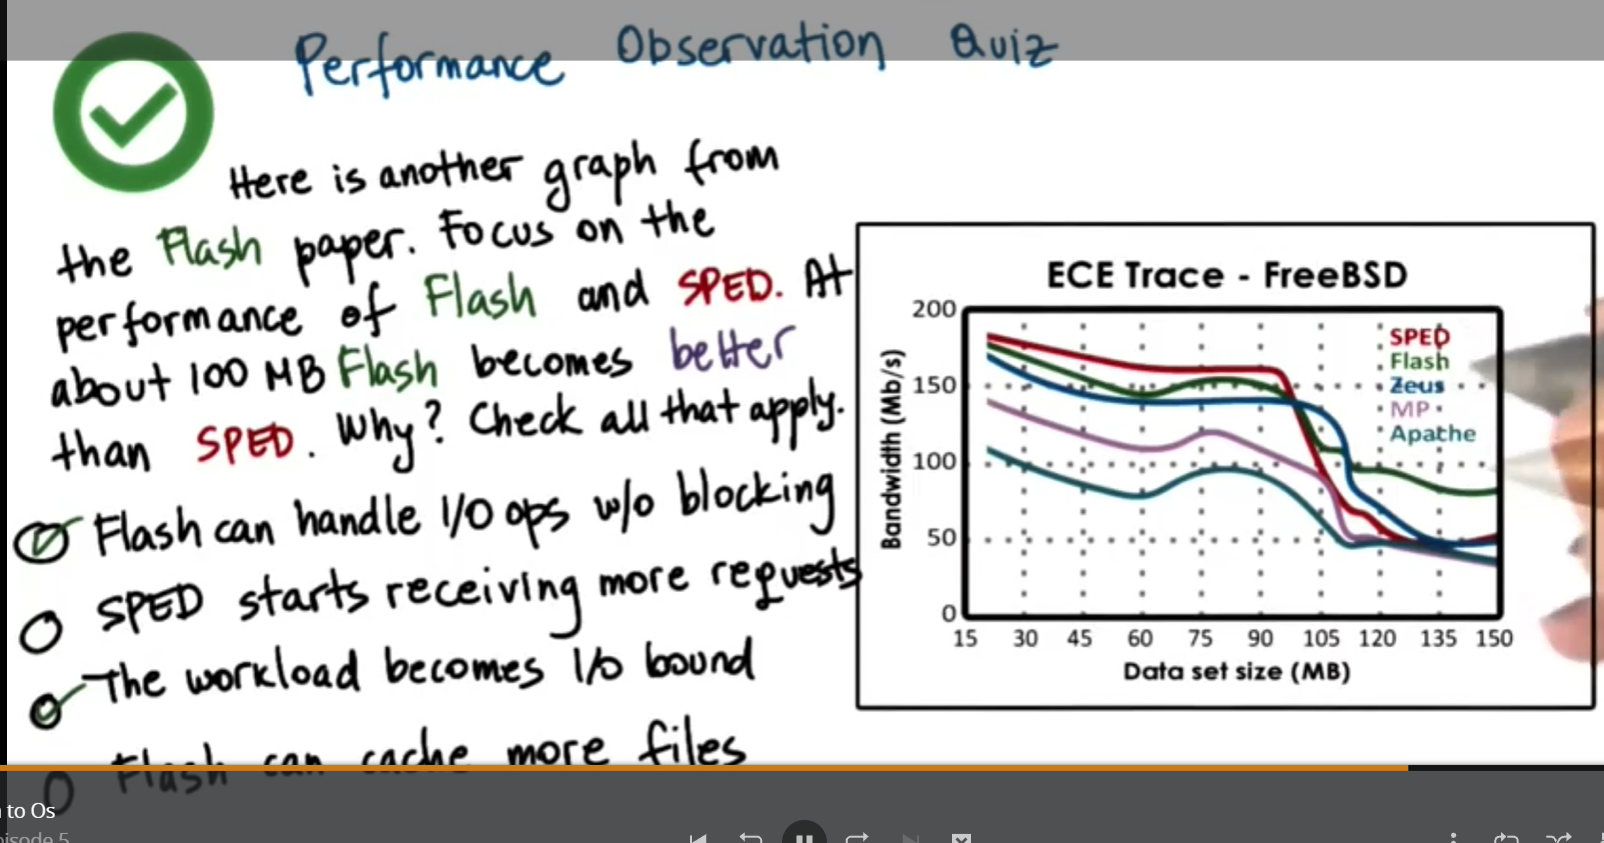

## Design Relevant Experiments
1. Relevant experiments: statements about a solution, that others believe in and care for


### Purpose of relevant experiments:
Example: web server experiemnt
1. clients: response time
1. Operators: throughput

Possible goals:
1. -response time, +throughput: great
1. -response time: OK
1. -response time, -throughput: may be usefule
1. maintian response time when request rate increases
Goals: metrics & configuration of experiments

### Picking the right metrics
"Rule of thumb" for Picking Metrics:
1. "Standard" metrics: broader audience
1. Metrics answering the "why? what? who?)" questions: why I do, what to improve or udnerstand, who cares for this
    1. client performance:
        1. response time
        1. number of timedout request
    1. operator costs:
        1. throughput
        1. costs

### Pick the right configuration space
1. System Resources:
    1. Hardware (CPU, memory, etc.)
    1. Software (Number of threads, queue sizes, etc.)
1. Wrokload
    1. Webserver
        1. request rate
        1. nubmer of concurrent requests
        1. file size
        1. access pattern
1 Pick
    1. choose a subset of configuration parameters which are likely most impactful when you change the metrics when you are observing
    1. pick ranges for each variable factor, the range must be relevant
    1. pick relevant workload
    1. include best/worst case scenarios, which demostrate some limitations/opportunities
    1. pick useful combinations of factors
        1. many just reiterate the same point
    1. Compare apples to apples
        1. poor example:
            1. large workload, small resources size
            1. small workload, large resources size
            1. Conclusion: performace imporoves when increase resources (wrong)
1. Competition/Baseline
    1. State-of-the-art
    1. Most common practice
    1. ideal best/worst case scenarios
1. run test cases n times
1. compute metrics (average)
1. represent results
1. Conclusion

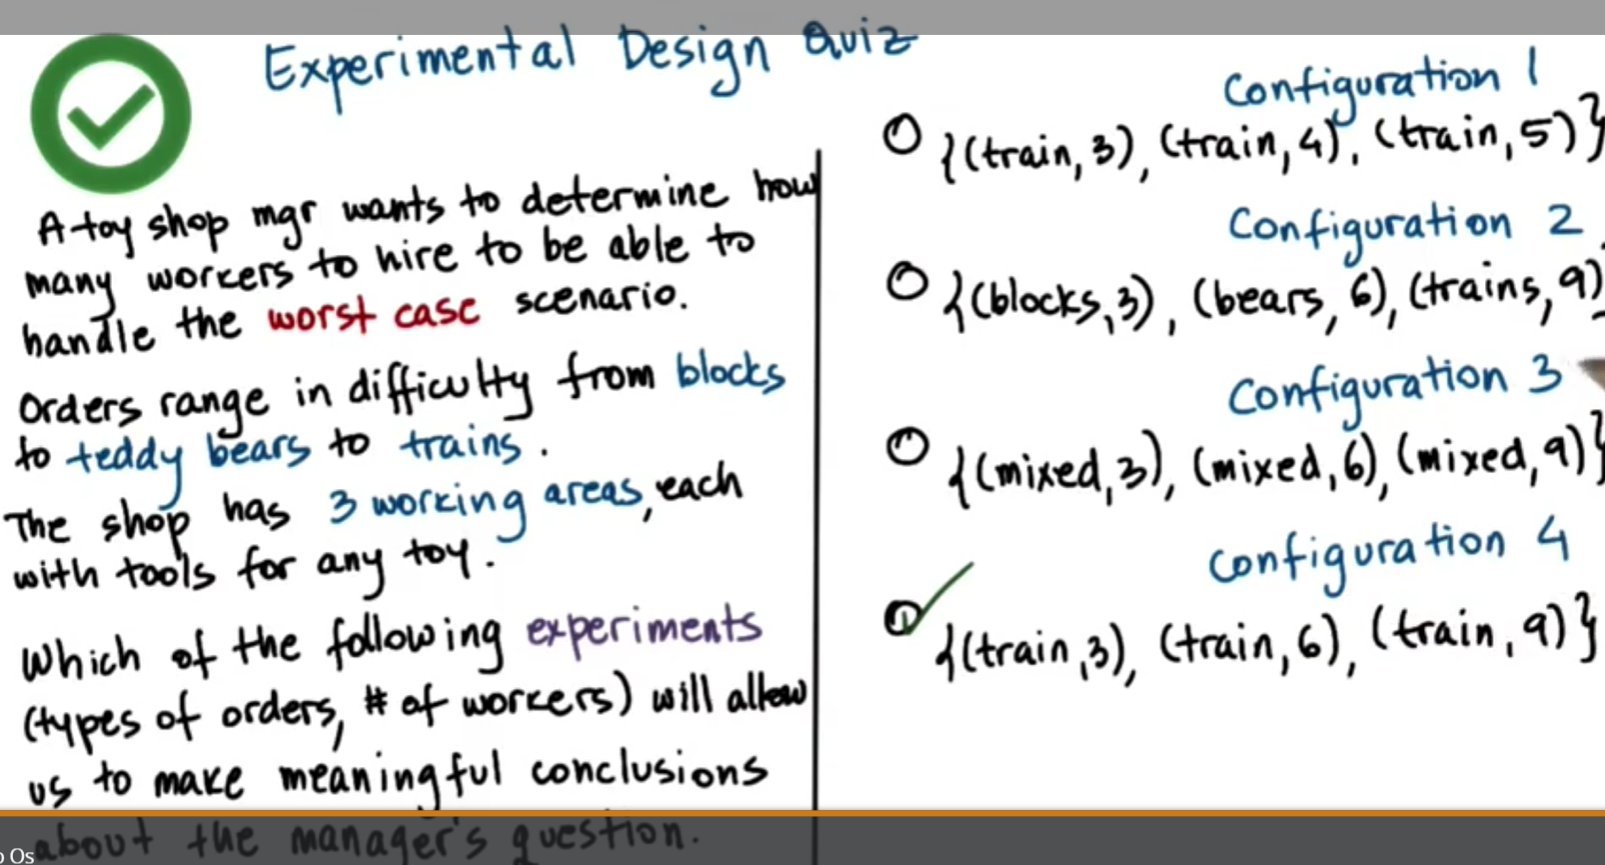